In [187]:
%run utils.ipynb

In [188]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
import scipy


def kurtosis(X, ica):
    transformed = ica.transform(X)
    kurtosis = scipy.stats.kurtosis(transformed)
    kurtosis = sorted(kurtosis, reverse = True)
#     kurtosis = MinMaxScaler(feature_range=(0,10))
    return kurtosis

def ica_n_components(data):
    np.random.seed(5)
    n_components = data['n_features']
    n_components_range = list(range(1,n_components+1))
    decision_tree = DecisionTreeClassifier()
    ica = FastICA(n_components=n_components)
    pipe = Pipeline(steps=[('ica', ica), ('decisionTree', decision_tree)])
    # Plot the ICA spectrum
    ica.fit(data['X'])

    fig, ax = plt.subplots()
    _kurt = kurtosis(data['X'],ica)
    ax.bar(n_components_range, _kurt,color="C0")
    plt.axis('tight')
    plt.xlabel('n_components')
    ax.set_ylim(bottom=0,top=100)
    ax.set_ylabel('kurtosis', color='C0')

    gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components_range), cv = 3)
    gridSearch.fit(data['X'],data['y'])
    results = gridSearch.cv_results_
    ax1 = ax.twinx()

    #Plotting the accuracies and best component
    ax1.plot(results['mean_test_score'], linewidth = 2, color = 'C1')
    ax1.set_ylabel('Mean Cross Validation Accuracy', color='C1')
    best_n = gridSearch.best_estimator_.named_steps['ica'].n_components
    ax1.axvline(best_n, linestyle=':', label='n_components chosen', linewidth = 2, color="C3")

    plt.legend(prop=dict(size=12))
    plt.title('Accuracy/kurtosis for ICA %s \n (best n_components=%d, kurtosis>%0.2f)'%(data['name'], best_n ,_kurt[best_n-1]))
    plt.show()
    
def reconstruction_error(data):
    n_components_range = list(range(1, data['n_features']+1))
    vals = []
    for n_component in n_components_range:
        reducer = FastICA(n_components=n_component)
        transform = reducer.fit_transform(data['X'])
        inverse = reducer.inverse_transform(transform)
        _error = ((data['X'] - inverse) ** 2).mean()
        vals.append({
            'error': _error
        })
    df = pd.DataFrame(vals)
    return df
    
def plot_reconstruction_error(df):
    plt.plot(df['error'], label=data['name'])
    plt.legend()
    plt.title("Reconstruction error")
    plt.show()

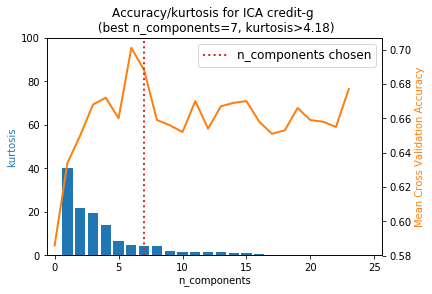

In [180]:
ica_n_components(cdata)

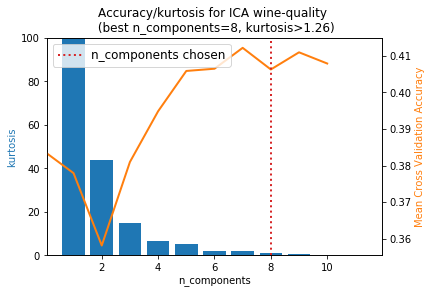

In [181]:
np.random.seed(20)
ica_n_components(wdata)

In [189]:
wdata['ica_n'] = 8
cdata['ica_n'] = 7

In [190]:
# Set number of components as determined by the analysis
def ica_reduced_data(data):
    np.random.seed(100)
    n_components = data['n_features']
    ica = FastICA(n_components=n_components)
    ica.fit(data['X'])
    transformed = ica.transform(data['X'])
    kurtosis = scipy.stats.kurtosis(transformed)
    cols = list(range(0,transformed.shape[1]))
    df = pd.DataFrame({'kurtosis':kurtosis,'component':cols})
    _df = df.sort_values(by='kurtosis', ascending=False).head(data['ica_n'])
    cols_to_keep = _df['component'].values
    transformed_df = pd.DataFrame(transformed)
    transformed_df = transformed_df[cols_to_keep]
    return transformed_df.values




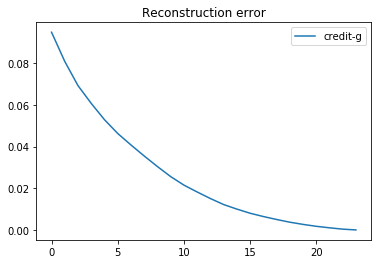

11
13


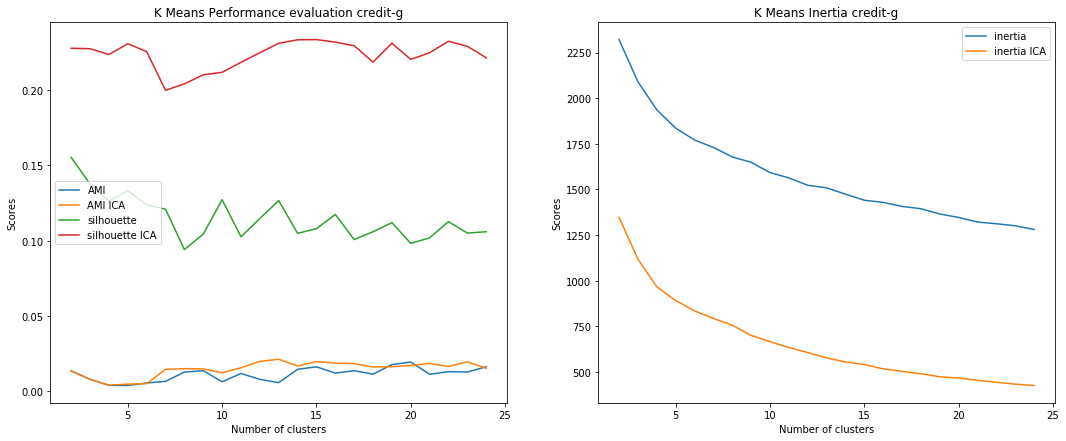

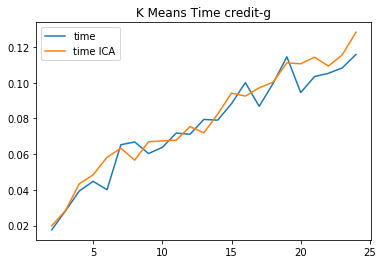

      AMI       ARI       NMI  accuracy  completeness  f1_score  homogenity  \
0  0.0136  0.051325  0.014546     0.527      0.014684  0.522151     0.01441   

       inertia       init  mutual_info  n_clusters  precision  recall  \
0  2320.844198  k-means++     0.008802           2   0.517391   0.527   

   silhouette      time  v-measure  
0     0.15531  0.019862   0.014546  
------
      AMI       ARI       NMI  accuracy  completeness  f1_score  homogenity  \
0  0.0136  0.051325  0.014546     0.527      0.014684  0.522151     0.01441   

       inertia       init  mutual_info  n_clusters  precision  recall  \
0  1346.983119  k-means++     0.008802           2   0.517391   0.527   

   silhouette      time  v-measure  
0    0.227792  0.017574   0.014546  
19
2


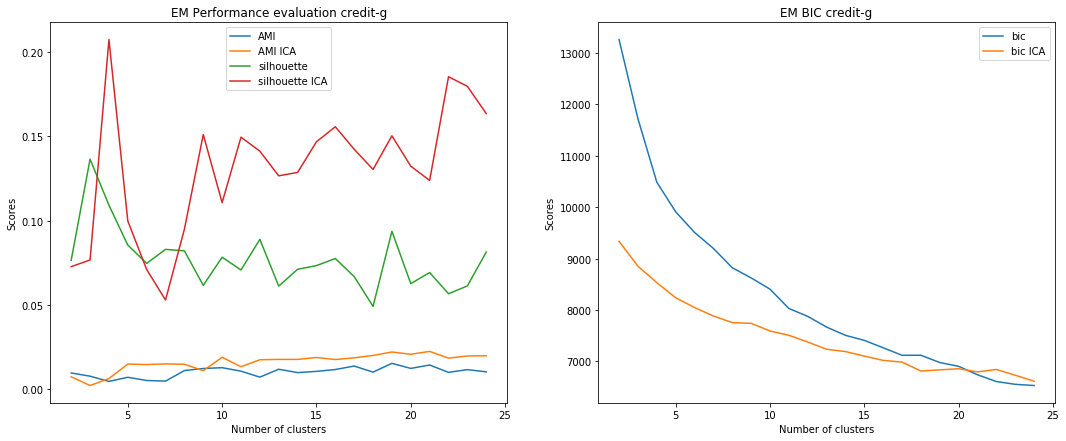

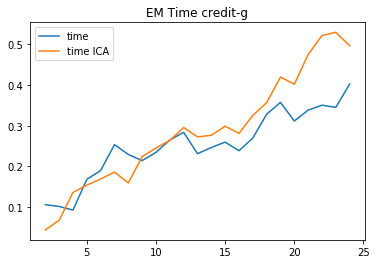

        AMI      ARI       NMI  accuracy           aic           bic  \
0  0.009766 -0.00694  0.011019     0.305  13011.834362  13262.129881   

   completeness  f1_score  homogenity    init  mutual_info  n_clusters  \
0      0.010504  0.388889    0.011559  gmm-em     0.007061           2   

   precision  recall  silhouette      time  v-measure  
0   0.536432   0.305    0.076612  0.044118   0.011006  
------
        AMI       ARI       NMI  accuracy          aic          bic  \
0  0.007495 -0.022861  0.008401      0.48  9253.990785  9337.422625   

   completeness  f1_score  homogenity    init  mutual_info  n_clusters  \
0      0.008494  0.474912     0.00831  gmm-em     0.005076           2   

   precision  recall  silhouette      time  v-measure  
0    0.46993    0.48    0.072786  0.106178   0.008401  


In [191]:
data = cdata
method = "ICA"

# Reconstruction Error
dfr = reconstruction_error(cdata)
dfr.to_csv(f"./results/rerror_{method.lower()}_{data['name']}.csv", index=False )
plot_reconstruction_error(dfr)

# Reduce dimension
reduced_data = ica_reduced_data(data)

# Reduce dimension
reduced_data = PCA(n_components=data['ica_n']).fit_transform(data['X'])
    
# Performances
n_clusters_range = list(range(2, data['n_features']+1))

## Kmeans
dfk = performance_k_means(reduced_data, 
                              data['y'], 
                              data['name'], 
                              n_clusters_range=n_clusters_range)
dfk.to_csv(f"./results/km_{method.lower()}_{data['name']}.csv", index=False )
reduced_data_k_means_perf(data, reduced_data, n_clusters_range, method=method)

## EM
dfe = performance_em(reduced_data, 
                              data['y'], 
                              data['name'], 
                              n_clusters_range=n_clusters_range)
dfe.to_csv(f"./results/em_{method.lower()}_{data['name']}.csv", index=False )
reduced_data_em_perf(data, reduced_data, n_clusters_range, method=method)


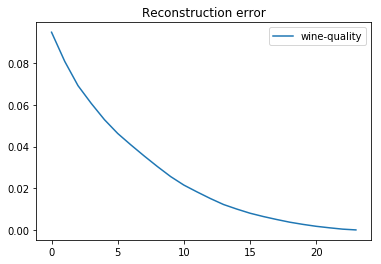

2
0


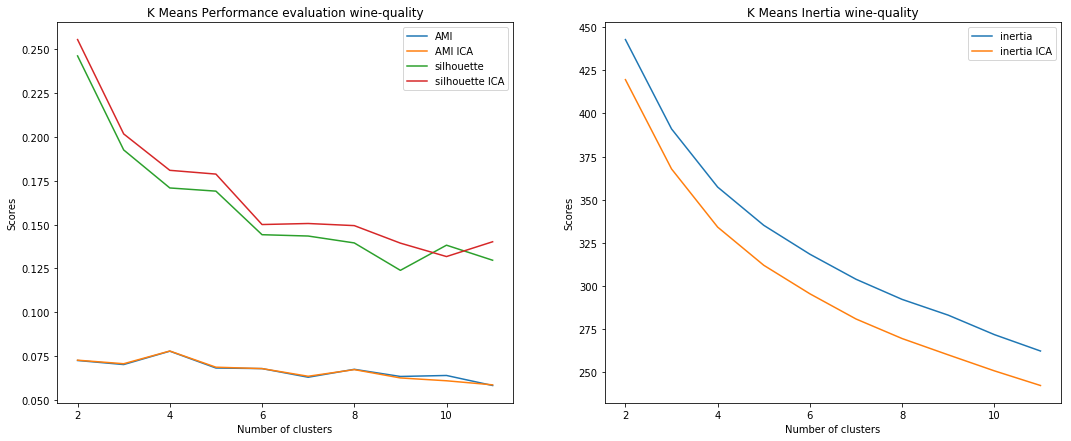

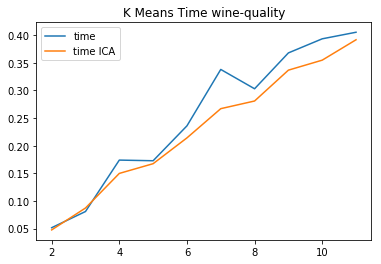

        AMI       ARI       NMI  accuracy  completeness  f1_score  homogenity  \
5  0.062941  0.042266  0.078396  0.170478      0.064847   0.21876    0.094775   

      inertia       init  mutual_info  n_clusters  precision    recall  \
5  303.884606  k-means++     0.122302           7    0.32078  0.170478   

   silhouette      time  v-measure  
5    0.143471  0.266966   0.077006  
------
        AMI      ARI       NMI  accuracy  completeness  f1_score  homogenity  \
5  0.063497  0.04233  0.079073  0.064108      0.065402  0.090588    0.095601   

      inertia       init  mutual_info  n_clusters  precision    recall  \
5  280.852729  k-means++     0.123368           7   0.270468  0.064108   

   silhouette      time  v-measure  
5    0.150616  0.337952   0.077669  
2
0


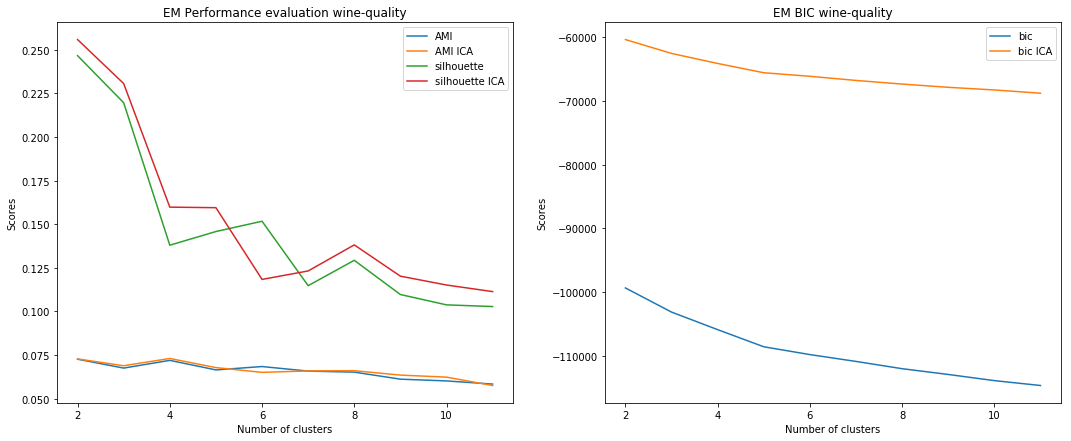

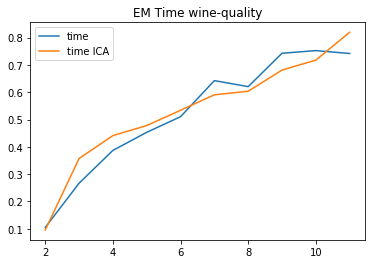

        AMI       ARI       NMI  accuracy            aic            bic  \
5  0.065826  0.042798  0.081983  0.171294 -111466.340671 -110881.648269   

   completeness  f1_score  homogenity    init  mutual_info  n_clusters  \
5       0.06772  0.224067     0.09925  gmm-em     0.128077           7   

   precision    recall  silhouette      time  v-measure  
5   0.333372  0.171294    0.114796  0.590707   0.080508  
------
        AMI       ARI       NMI  accuracy           aic           bic  \
5  0.065941  0.044504  0.081829  0.066558 -67238.802433 -66790.538259   

   completeness  f1_score  homogenity    init  mutual_info  n_clusters  \
5      0.067846  0.095226    0.098694  gmm-em     0.127359           7   

   precision    recall  silhouette      time  v-measure  
5   0.291824  0.066558    0.123241  0.642652   0.080413  


In [192]:
data = wdata
method = "ICA"

# Reconstruction Error
dfr = reconstruction_error(cdata)
dfr.to_csv(f"./results/rerror_{method.lower()}_{data['name']}.csv", index=False )
plot_reconstruction_error(dfr)

# Reduce dimension
reduced_data = ica_reduced_data(data)

# Reduce dimension
reduced_data = PCA(n_components=data['ica_n']).fit_transform(data['X'])
    
# Performances
n_clusters_range = list(range(2, data['n_features']+1))

## Kmeans
dfk = performance_k_means(reduced_data, 
                              data['y'], 
                              data['name'], 
                              n_clusters_range=n_clusters_range)
dfk.to_csv(f"./results/km_{method.lower()}_{data['name']}.csv", index=False )
reduced_data_k_means_perf(data, reduced_data, n_clusters_range, method=method)

## EM
dfe = performance_em(reduced_data, 
                              data['y'], 
                              data['name'], 
                              n_clusters_range=n_clusters_range)
dfe.to_csv(f"./results/em_{method.lower()}_{data['name']}.csv", index=False )
reduced_data_em_perf(data, reduced_data, n_clusters_range, method=method)
